## 1. IMPORTING MODULES AND INSTALLING DEPENDENCIES FROM requirements.txt

In [30]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt

## 2. Remove Doggy images and Declaring Variable we use Later

In [31]:
Main_dir = "/Users/somesh/Desktop/IITH_PROJECTS/Human_Emotion_detector"
Image_data_dir = "/Users/somesh/Desktop/IITH_PROJECTS/Human_Emotion_detector/Image_data"
allowed_extensions = ["jpeg" ,"png" ,"jpg", "bmp"]
IMAGE_SIZE = 256
TRAIN_RATIO  = 0.6
VALIDATION_RATIO  = 0.3
TEST_RATIO = 0.1

In [32]:
for image_class in os.listdir(Image_data_dir):
    for image in os.listdir(os.path.join(Image_data_dir,image_class)):
        image_path = os.path.join( Image_data_dir,image_class,image )
        
        image_type = image.split('.')[-1]
        if image_type not in allowed_extensions:
            os.remove(image_path)

In [33]:
# tf.keras.utils.image_dataset_from_directory?

## 3. Load Data

In [34]:
image_data = tf.keras.utils.image_dataset_from_directory(
    directory = Image_data_dir,
    batch_size = 32,
    image_size  = (IMAGE_SIZE,IMAGE_SIZE),
    shuffle = True,
    seed = 23
)

IMAGE_CLASS_NAMES = image_data.class_names

Found 305 files belonging to 2 classes.


In [35]:
print(f"image class names are {IMAGE_CLASS_NAMES}")
print(f"Total number of batches are {len(image_data)}")

image class names are ['happy', 'sad']
Total number of batches are 10


In [36]:
image_data_iterator = image_data.as_numpy_iterator()
first_batch = image_data_iterator.next() #is a tuple of numpy arrays(image, label)

#M1
print(f" shape of each batch image and label is {first_batch[0].shape} and {first_batch[1].shape} respectively")

#M2
images,labels = first_batch
print(f" shape of each batch image and label is {images.shape} and {labels.shape} respectively")


 shape of each batch image and label is (32, 256, 256, 3) and (32,) respectively
 shape of each batch image and label is (32, 256, 256, 3) and (32,) respectively


## 4. Visualise some images from data

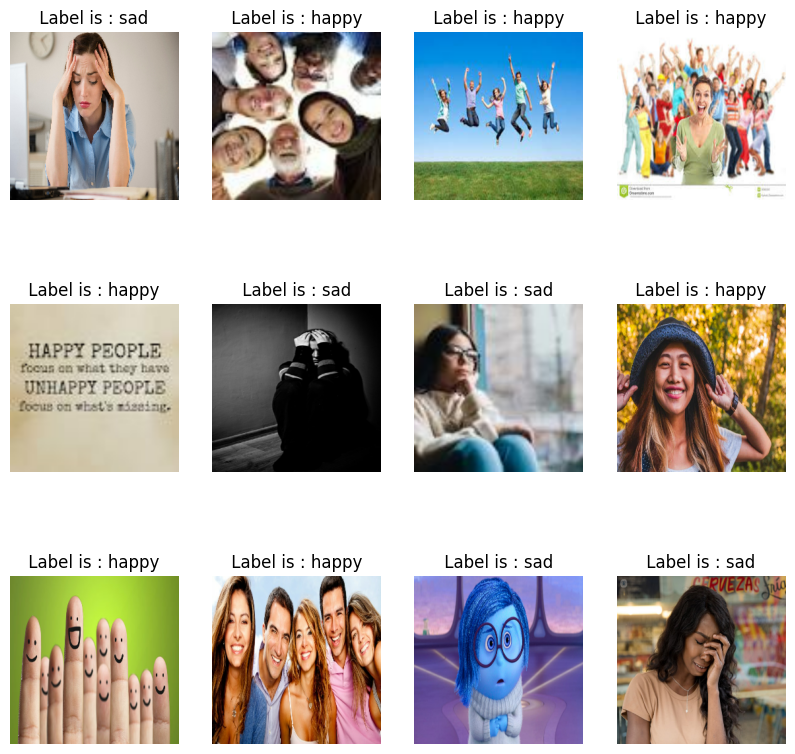

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(first_batch[0][i].astype("uint8"))  
    plt.title(f" Label is : {IMAGE_CLASS_NAMES[first_batch[1][i]]} ") 
    plt.axis("off")
    
plt.show()

#Use .astype("uint8") when your pixel values are in [0, 255] but stored as float, to ensure plt.imshow() interprets them correctly.
#Because first_batch is already nupy iterator thats why we dont need to explicitly telll imshow to use .numpy() to convert tensor to numpy 

## 5.Scale Data

In [38]:
def normalise_image(image,label):
    image = image / (IMAGE_SIZE - 1)
    return image, label

image_data = image_data.map(normalise_image)

## 6. Split data into train test and Validation

In [39]:
train_image_size = int(len(image_data)*TRAIN_RATIO)
validation_image_size = int(len(image_data)*VALIDATION_RATIO)
test_image_size = int(len(image_data)*TEST_RATIO)
print(f"number of batches in train data : {train_image_size}")
print(f"number of batches in test data : {test_image_size}")
print(f"number of batches in validation data : {validation_image_size}")

number of batches in train data : 6
number of batches in test data : 1
number of batches in validation data : 3


In [40]:
train_image = image_data.take(train_image_size)
validation_image = image_data.skip(train_image_size).take(validation_image_size)
test_image = image_data.skip(train_image_size + validation_image_size).take(test_image_size)

## 7. Building Deep Learning Model

In [41]:
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,Flatten,MaxPooling2D,Input,Activation
from tensorflow.keras.callbacks import EarlyStopping

def make_image_model(bn):
    
    image_model = Sequential()

    image_model.add(Input((IMAGE_SIZE,IMAGE_SIZE,3)))

    if bn == True:
        image_model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='valid',kernel_initializer='glorot_uniform'))
        image_model.add(MaxPooling2D(2,2))
        image_model.add(BatchNormalization())
    else : 
        image_model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='valid',kernel_initializer='glorot_uniform'))
        image_model.add(MaxPooling2D(2,2))
        # image_model.add(BatchNormalization())
        
    
    if bn == True:
        image_model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='valid',kernel_initializer='glorot_uniform'))
        image_model.add(MaxPooling2D(2,2))
        image_model.add(BatchNormalization())
    else:
        image_model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='valid',kernel_initializer='glorot_uniform'))
        image_model.add(MaxPooling2D(2,2))
        # image_model.add(BatchNormalization())
        
        
    if bn == True:
        image_model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='valid',kernel_initializer='glorot_uniform'))
        image_model.add(MaxPooling2D(2,2))
        image_model.add(BatchNormalization())
    else : 
        image_model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='valid',kernel_initializer='glorot_uniform'))
        image_model.add(MaxPooling2D(2,2))
        # image_model.add(BatchNormalization())
            
           
    image_model.add(Flatten())

    image_model.add(Dense(units=128,use_bias=True,activation='relu',kernel_initializer='glorot_uniform'))
    image_model.add(Dropout(0.2))

    image_model.add(Dense(units=len(IMAGE_CLASS_NAMES),activation='softmax'))
    
    return image_model


#another way to add batch norm
        # image_model.add(Conv2D(filters=16,kernel_size=(3,3),padding='valid',kernel_initializer='glorot_uniform'))
        # # image_model.add(BatchNormalization())
        # image_model.add(Activation('relu'))
        # image_model.add(MaxPooling2D(2,2))
        
#or here 
        #image_model.add(Dense(units=1,activation='sigmoid))
        #image_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])       

 

In [42]:
bn_image_model  = make_image_model(bn=True)
image_model = make_image_model(bn=False)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 127, 127, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 30, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,853,554 (7.07 MB)

 Trainable params: 1,853,426 (7.07 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 630ms/step - accuracy: 0.5538 - loss: 2.3282 - val_accuracy: 0.5000 - val_loss: 0.7149
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - accuracy: 0.9000 - loss: 0.6401 - val_accuracy: 0.6771 - val_loss: 0.5691
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.9202 - loss: 1.6194 - val_accuracy: 0.7396 - val_loss: 0.4856
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - accuracy: 0.9408 - loss: 0.4227 - val_accuracy: 0.6771 - val_loss: 0.7757
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 481ms/step - accuracy: 0.9110 - loss: 0.4334 - val_accuracy: 0.5729 - val_loss: 0.8678
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step - accuracy: 0.9460 - loss: 0.1691 - val_accuracy: 0.5521 - val_loss: 0.6664
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.9731 - loss: 0.2095 - val_accuracy: 0.5417 - val_loss: 1.4249
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step - accuracy: 0.9704 - loss: 0.2504 - val_accuracy: 0.5521 - val_loss:

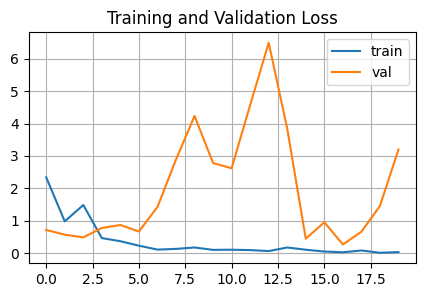

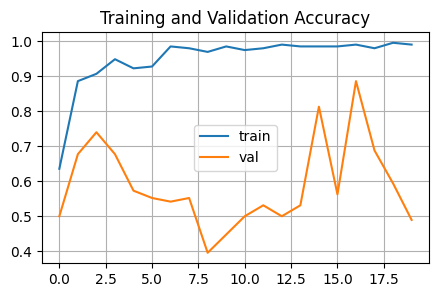

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 0.4118 - loss: 1.9994
accuracy of prebn model is : [1.9994069337844849, 0.4117647111415863]


In [43]:
es = EarlyStopping(patience=3,restore_best_weights=True,monitor='loss')
bn_image_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    

bn_image_model.summary()

hist = bn_image_model.fit(train_image,epochs=20,validation_data=validation_image,callbacks=[es],batch_size=32)

plt.figure(figsize=(5,3))
plt.title('Training and Validation Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'],label='val')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.show()

print(f"accuracy of prebn model is : {bn_image_model.evaluate(test_image)}")


## 8. Finally Taking image_model

In [44]:
es = EarlyStopping(patience=3,restore_best_weights=True,monitor='val_loss')
image_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

image_model.summary()

hist = image_model.fit(train_image,epochs=25,validation_data=validation_image,callbacks=[es],batch_size=32)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,853,298 (7.07 MB)

 Trainable params: 1,853,298 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.4948 - loss: 0.9893 - val_accuracy: 0.4271 - val_loss: 0.6622
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step - accuracy: 0.5464 - loss: 0.6474 - val_accuracy: 0.5521 - val_loss: 0.6113
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.6315 - loss: 0.6004 - val_accuracy: 0.7917 - val_loss: 0.5595
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.7525 - loss: 0.5612 - val_accuracy: 0.7188 - val_loss: 0.4929
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.7500 - loss: 0.5408 - val_accuracy: 0.8125 - val_loss: 0.4602
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.8628 - loss: 0.4179 - val_accuracy: 0.8750 - val_loss: 0.3824
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.8675 - loss: 0.3666 - val_accuracy: 0.8646 - val_loss: 0.3064
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 341ms/step - accuracy: 0.9122 - loss: 0.2912 - val_accuracy: 0.9271 - val_loss:

## 9. Plot Performance and see Accuracy

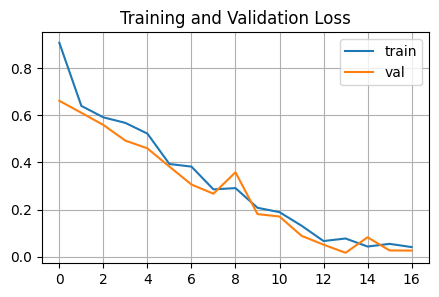

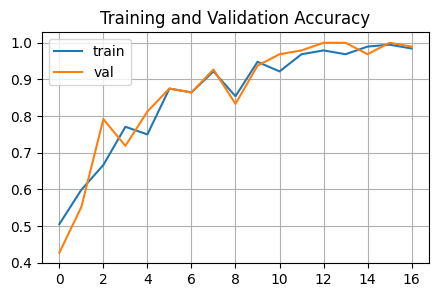

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - accuracy: 1.0000 - loss: 0.0185
accuracy of image model is : [0.018482768908143044, 1.0]


In [45]:
plt.figure(figsize=(5,3))
plt.title('Training and Validation Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(5,3))
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'],label='val')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.show()

print(f"accuracy of image model is : {image_model.evaluate(test_image)}")

## 10.Prediction on some Sample Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
predicted emotion is sad


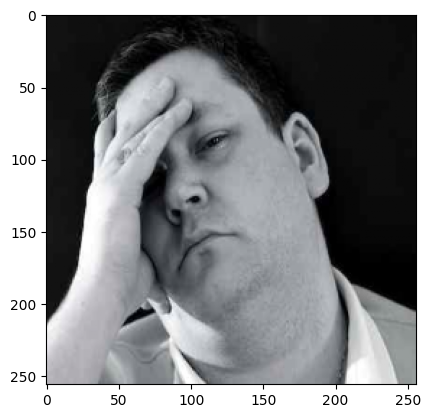

In [46]:
def predict_image_emotion(image_path,model):
    image = cv2.imread(image_path)
    image = cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
    image = image/(IMAGE_SIZE-1)
    plt.imshow(image)
    # print(f"image shape is {image.shape}")
    image = np.expand_dims(image,axis=0)
    # print(f"batch image shape is {image.shape}")
    layer_output = model.predict(image)  
    # print(f"layer output shape is {layer_output.shape}")
    result = np.argmax(layer_output)
    # print(f"result is {result}")
    print(f"predicted emotion is {IMAGE_CLASS_NAMES[result]}")
    
    
predict_image_emotion("/Users/somesh/Desktop/IITH_PROJECTS/Human_Emotion_detector/Sample test/sad-more-money.jpg",image_model)

## 11.Saving the model 

In [47]:
image_model.save(os.path.join(Main_dir,'models','image_model.h5'))

In [48]:
image_model = tf.keras.models.load_model(os.path.join(Main_dir,'models','image_model.h5'))    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
predicted emotion is happy


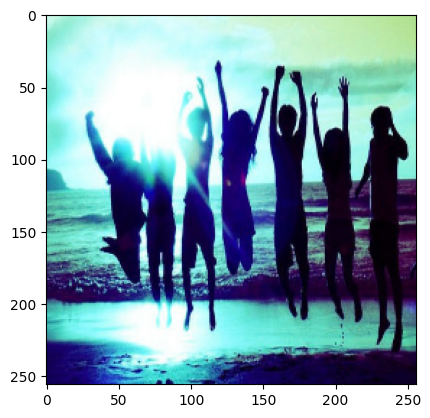

In [49]:
predict_image_emotion("/Users/somesh/Desktop/IITH_PROJECTS/Human_Emotion_detector/Sample test/e162ccda8ce0f197f8863f327add9233.jpg",image_model)

In [50]:
import pickle
pickle.dump(IMAGE_CLASS_NAMES,open(os.path.join(Main_dir,'models','image_classes.pkl'),'wb'))